# Abstract

In this study, we set out to design a data-driven system for automating credit decisions at a hypothetical bank. Our objective was to create a score function that captures the balance between potential revenue and risk, using predictive models trained on historical data to estimate the likelihood of loan repayment. Our primary drive as the hypothetical bank was to maximize profit, however, we observe that this choice has potentially negative impacts on our diverse borrowers.

# Data

We are diving into a [Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset) that simulates credit bureau data.

In [58]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

Here is a first look at the raw data:

In [59]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


I want to highlight several important features of this dataset.

* `loan_percent_income` is ratio of the loan amount to the individual's income
* `loan_int_rate` is the annual interest rate on the loan.
* `loan_status` tells us whether or not the individual defaulted on their loan. This a a binary feature where `1` indicates the individual **defaulted**, and `0` indicates the loan was **repaid** in full. This is our **Target Variable**.

Lets have a look at how common defaulting is in our training data:

In [60]:
df_train["loan_status"].value_counts(normalize=True)

loan_status
0    0.78242
1    0.21758
Name: proportion, dtype: float64

In the dataset, around 21% of borrowers default on their loan. This is going to be the our *base rate for prediction*.

In [61]:
df_train["person_age"].describe()

count    26064.000000
mean        27.734385
std          6.362612
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

There seems to be some slight errors in our data with the age of certain individuals. 144, although impressive, is highly unlikely. Thus, without context for why the data has such an outlier, I am going to filter our data to exclude persons over 100 years old. In addition, I will do some other basic data cleaning like removing NaN entries, encoding qualitative features, etc.

In [62]:
df_train = df_train[df_train["person_age"] < 100]

In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_train["cb_person_default_on_file"])

df_train["cb_person_default_on_file"] = le.transform(df_train["cb_person_default_on_file"])

df_train = df_train.dropna()

Now our data set looks like this!

In [64]:
df_train.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,1,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,0,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,0,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,0,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,14.91,1,0.25,0,2


# Exploration

Let's dive a bit into our data to see if we can pick up on any interesting trends.

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

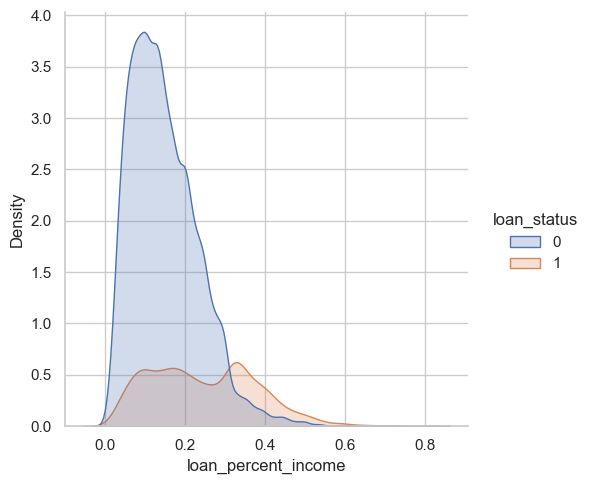

In [66]:
sns.displot(data=df_train, x="loan_percent_income", hue="loan_status", kind="kde", bw_adjust=0.9, fill=True, alpha=0.25)

The above figure uses Kernel Density Estimation (KDE), a technique that helps visualize the distribution of data points. In this case we are examining how loan_percent_income is distributed in our data set and its possible relation to defaulting on your loan. We can see here that there is a high density of people who repaid their loans where the loan amount factored between 10-20% of their annual income. This may point to the fact that 10-20% of ones income is a manageable amount, and where we see a spike in `1` around 35%+ may be an rate that is hard to pay off and thus lead to defaults. It is also notable that not many people are requesting loans that are 30%+ of their annual income.

<Axes: xlabel='cb_person_cred_hist_length', ylabel='loan_int_rate'>

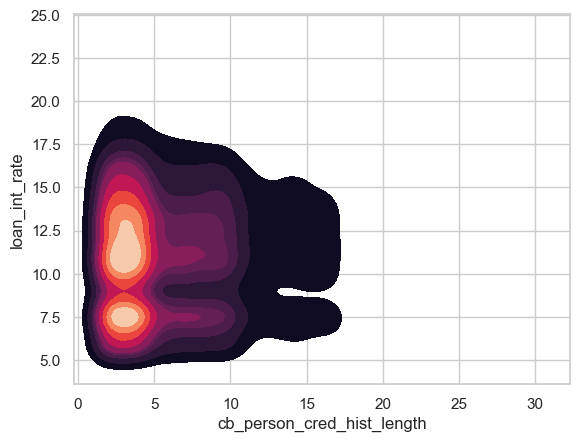

In [67]:
sns.kdeplot(data=df_train, x="cb_person_cred_hist_length", y="loan_int_rate", cmap="rocket", fill=True)

This is another KDE plot that shows the relation in loan interest rates given by the bank and an individuals credit history length. We can observe that there is a high density of people who have a credit history length between 0-5 years. Within this rage there are two hot spots for the interest rates on their loans, around 7.5% and around 11% interest. So although a large amount of people have relatively short credit histories, the bank are differentiating their offers based on other factors.

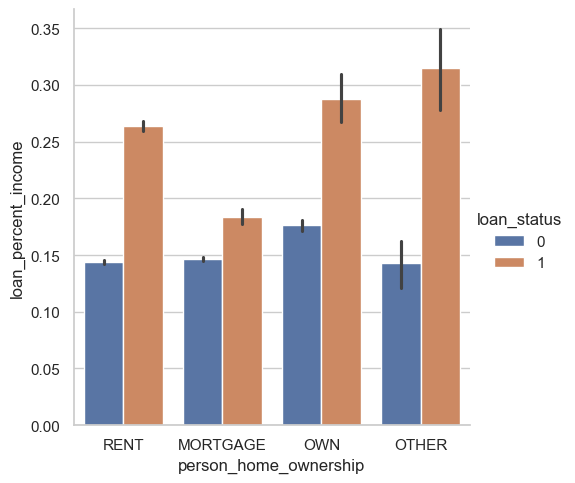

In [68]:
sns.catplot(data=df_train, kind="bar", x="person_home_ownership", y="loan_percent_income", hue="loan_status")

This figure really highlights the importance of loan_percent _income as a possible meaningful predictor of who will default. We see that across the board, regardless of home ownership type, those who repaid their loans requested loans that were around 15% of their annual income. However, those who defaulted on their loans were consistently requesting loans that were a much higher rate (ranging from ~17%-35%).

Let's examine how the connection between age, credit history length, and employment length.

In [69]:
import numpy as np

bins = [0, 5, 10, 15, 20, np.inf]
labels = ['0-5', '5-10', '10-15', '15-20', '20+']

df_train.groupby(
    pd.cut(df_train['cb_person_cred_hist_length'], bins=bins, labels=labels), observed=True
)[['person_age', 'person_emp_length']].agg(['mean'])

,person_age,person_emp_length
,mean,mean
cb_person_cred_hist_length,,
0-5,24.253351,4.277778
5-10,29.975727,5.417458
10-15,40.011823,5.982576
15-20,41.297771,6.046178
20+,57.318471,5.923567


As expected credit history length increases with age. However it is interesting to note that the employment length (time spent at an individuals last job) remain roughly the same, between 4-6 years on average. 

# Model Building

Now we will dive into creating a model that will hopefully do a good job at predicting who we should give loans to. As a bank what we care about is **profit**! However, to train a model that will get us good profit, I will start by finding features to train our model on that perform with high accuracy.

In [70]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


all_qual_cols = ["person_home_ownership", "loan_intent"]
all_quant_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "cb_person_default_on_file"]

df_train = pd.get_dummies(df_train)

LR = LogisticRegression(max_iter = 1000)
scaler = StandardScaler()

# df_train[all_quant_cols] = scaler.fit_transform(df_train[all_quant_cols])
score = 0
final_cols = []

X_train = df_train.drop(columns = "loan_status")
y_train = df_train["loan_status"]

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    LR.fit(X_train[cols], y_train)
    cross_val_scores = cross_val_score(LR, X_train[cols], y_train, cv = 5)
    if cross_val_scores.mean() > score:
      score = cross_val_scores.mean()
      final_cols = cols


print(f"The best model scored {score*100:.3f}% accuracy when testing on training data using: \n{final_cols}")    

The best model scored 84.875% accuracy when testing on training data using: 
['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_age', 'loan_percent_income']


This accuracy, although not stellar, should be high enough to hopefully be a good predictor to maximize our profit margins.

*But how are we going to decide who to give loans to?* Great question! We are going to give each loan applicant a score `s` which predicts their likelihood to default on a loan. Higher scores indicate greater reliability.

In [71]:
def linear_score(X, w):
    return X@w

The above function calculates our linear score as a function of the features *`X`* and a weight vector ***`w`***. We can get this vector of weight by fitting a Linear Regression model as shown below.

In [72]:
LR.fit(X_train[final_cols], y_train)
LR.coef_

array([[-7.59666254e-01, -9.36504060e-02, -1.80228891e+00,
         2.75434204e-01, -3.61277124e-03,  8.27700853e+00]])

In [73]:
w = LR.coef_[0]
s = linear_score(df_train[final_cols], w)

We now have `s` which is a vector of scores for each applicant. We can see the distribution of these scores below.

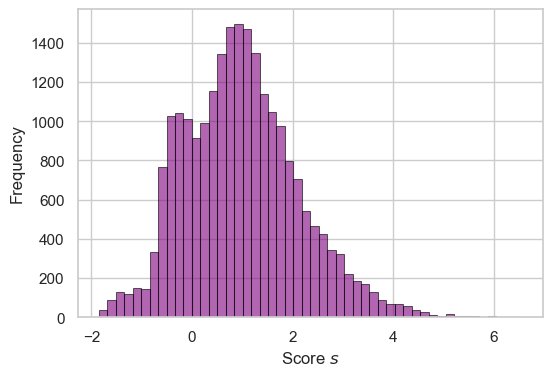

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(s, bins = 50, color = "purple", alpha = 0.6, linewidth = 0.75, edgecolor = "black")
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency") 

As a reminder, as the bank, we want to use these scores to determine who we should give loans to in order to turn the maximum profit. Thus we need to determine a threshold at which we make the most money and use it as a cutoff.

Below you can find some simplified functions for how we determine our profit margins. 
- The `calculate_profit` formula is used when a loan is fully repaid and assumes that the profit earned each year by the bank on a 10-year loan is equal to 25% of the interest rate each year, with the other 75% of the interest going into various costs to manage the bank. This corresponds to the *True Negative* category.
- The `calculate_loss` formula is employed for defaults, it uses the same mechanism as above but assumes that the borrower defaults three years into the loan and that the bank loses 70% of the principal. This corresponds to the *False Negative* category.

In [75]:
def calculate_profit(df_train):
    return (df_train["loan_amnt"]*(1 + 0.25*(df_train["loan_int_rate"]/ 100))**10) - df_train["loan_amnt"]

def calculate_loss(df_train):
    return (df_train["loan_amnt"]*(1 + 0.25*(df_train["loan_int_rate"]/ 100))**3) - (1.7*df_train["loan_amnt"])

Below, we are testing threshold values between -4 and 4 and using our formulas to calculate our net gain at each interval. Our best threshold is the one that corresponds to the highest net gain.

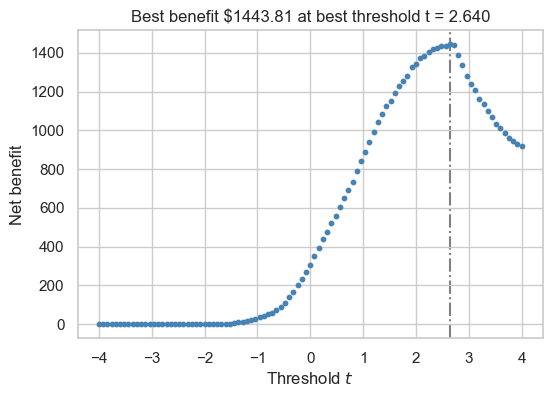

In [76]:
best_profit = 0
best_threshold = 0

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(-4, 4, 101): 
    y_pred = s >= t
    tn = ((y_pred == 0) & (y_train == 0))
    fn = ((y_pred == 0) & (y_train == 1))

    gain = calculate_profit(df_train[tn]).sum() + calculate_loss(df_train[fn]).sum()
    gain /= len(df_train)
    ax.scatter(t, gain, color = "steelblue", s = 10)
    if gain > best_profit: 
        best_profit = gain
        best_threshold = t


ax.axvline(best_threshold, linestyle = "-.", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net benefit", title = f"Best benefit ${best_profit:.2f} at best threshold t = {best_threshold:.3f}")

Our net gain per person when we only give loans to people with a risk score of 2.64 or above is $1443.81 per person! Lets see if this threshold works on data the model has never seen before...

# Bank Evaluation

Here we are importing the test data set and applying the same preprocessing steps that we used on the training data.

In [77]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

df_test["cb_person_default_on_file"] = le.transform(df_test["cb_person_default_on_file"])
df_test = df_test.dropna()
df_test = pd.get_dummies(df_test)
# df_test[all_quant_cols] = scaler.fit_transform(df_test[all_quant_cols])

X_test = df_test.drop(columns = "loan_status")
y_test = df_test["loan_status"]

We once again calculate a net gain per person score...

In [78]:
test_scores = linear_score(df_test[final_cols], w)
y_pred = test_scores > best_threshold

test_tn = ((y_pred == 0) & (y_test == 0))
test_fn = ((y_pred == 0) & (y_test == 1))

test_gain = calculate_profit(df_test.loc[test_tn]).sum() + calculate_loss(df_test.loc[test_fn]).sum()
test_gain /= len(df_test)

In [79]:
print(f"The net benefit on the test set is ${test_gain:.2f}")

The net benefit on the test set is $1384.50


Our model did not perform as well on the test data... however, we are still making quite a bit of profit per person from the bank!

# Borrower's Evaluation

This is all fine and dandy for the bank... make money = bank happy... but what about the borrowers?

We are adding columns to our data frame that show each borrowers score and our models prediction.

In [80]:
df_test["person_risk"] = test_scores
df_test["loan_status_pred"] = y_pred

In [135]:
(df_test["loan_status_pred"] == df_test["loan_status"]).mean()

np.float64(0.8474960739835979)

Our model accurately predicted who would default on their loan 84.75% of the time. So the majority of people who would have defaulted on their loans were accurately denied... but who exactly are the people?

### Age Group Disparity

Lets break down how the model treats people of a certain age groups.

<Axes: xlabel='person_age', ylabel='person_risk'>

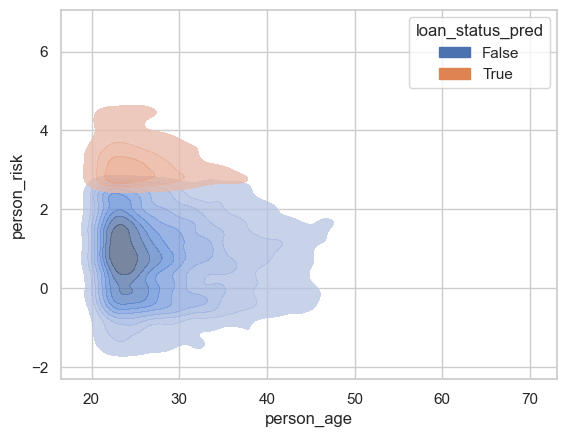

In [122]:
sns.kdeplot(data = df_test, x = "person_age", y = "person_risk", hue = "loan_status_pred", alpha = 0.75, fill = True, bw_adjust=0.7)

<Axes: xlabel='person_age', ylabel='person_risk'>

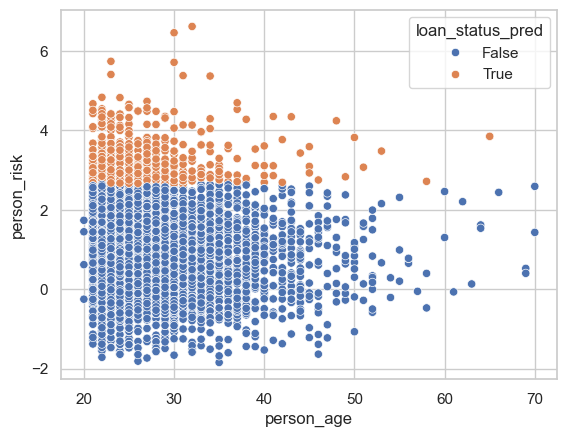

In [142]:
sns.scatterplot(data = df_test, x = "person_age", y = "person_risk", hue = "loan_status_pred")

We can see that most of the people who are receiving loans are under the age age of 40, with a majority falling between 20-30 years old. This makes sense as many of our applicants fall into this age range. This may be a little unfair for persons aged over 40...

### Medical Loans

How about people who are applying for medical loans. I highly important demographic of borrowers whose health and livelihoods may be contingent on access to a loan. *What fraction of the test dataset consists of medical loans that were approved?*

In [143]:
app_med_loans = (df_test["loan_intent_MEDICAL"] == True) & (df_test["loan_status_pred"] == False)
print(f"Only {app_med_loans.mean()*100:.2f}% of people applying for medical loans were approved")


Only 16.66% of people applying for medical loans were approved


In [137]:
def_rate_med_loans = (df_test["loan_intent_MEDICAL"] == True) & (df_test["loan_status"] == 1)
print(f"While only {def_rate_med_loans.mean()*100:.2f}% actually defaulted on their medical loans")


While only 5.32% actually defaulted on their medical loans


This is quite harrowing... operating on a purely profit based system is taking loans away from people who may really need this money and would not have defaulted! We will dive into the fairness of this decision later...

### Educational Loans

Lets see our model treats people applying for educational loans.

In [144]:
app_edu_loans = (df_test["loan_intent_EDUCATION"] == True) & (df_test["loan_status_pred"] == False)
print(f"Only {app_edu_loans.mean()*100:.2f}% of people applying for education loans were approved")

Only 18.71% of people applying for education loans were approved


In [139]:
def_rate_edu_loans = (df_test["loan_intent_EDUCATION"] == True) & (df_test["loan_status"] == 1)
print(f"While only {def_rate_edu_loans.mean()*100:.2f}% actually defaulted on their loans")


While only 3.44% actually defaulted on their loans


Once again we are denying loans to a huge amount of people who in reality paid off their loans.

### Business Venture Loans

In [145]:
app_bus_loans = (df_test["loan_intent_VENTURE"] == True) & (df_test["loan_status_pred"] == False)
print(f"Only {app_bus_loans.mean()*100:.2f}% of people applying for business venture loans were approved")

Only 15.42% of people applying for business venture loans were approved


In [ ]:
def_rate_bus_loans = (df_test["loan_intent_VENTURE"] == True) & (df_test["loan_status"] == 1)
print(f"While only {def_rate_bus_loans.mean()*100:.2f}% actually defaulted on their loans")


While only 2.46% actually defaulted on their loans


Once again we denied people who would have paid back their loans!

# Fairness Discussion

We observed some trends in our model that seemed pretty unfair, people who would have paid off their loans were denied... but what exactly does it mean to be *fair*? Fairness should be making a model that makes **decisions without bias** towards certain groups, especially dealing with sensitive features like race, gender, or socioeconomic status. Fairness also constitutes **taking into account features that are relevant** to the situation. At face value our model is treating people pretty harshly across the board with regards to the intent of their loan. We do however consider people age in the model, and we do seem to have a slight bias towards younger people... But in the medical loan situation, doesn't it seem unfair that people are being denied. doesn't the severity / intent behind the loan seem like an important and **relevant** factor? In a sense we are being biased towards people who need the money... people who are ill should be treated with extra care and that should be a relevant factor in where we draw our threshold and how we train our model.

# Conclusion

Our analysis revealed that automated decision system can be beneficial to a bank’s overall profitability by approving loans only when the expected risk-adjusted returns are maximized. However, the findings also reveal the importance of continuously monitoring the system's performance to ensure that it does not inadvertently disadvantage certain segments of the population. We observed that borrowers applying for loans of high importance, such as medical loans were drastically undeserved. In addition, older generation wer not given access to credit all in the name of profit. Ultimately, this exploration highlights the need for a balanced approach that integrates profit maximization with fairness and inclusivity taking into account other factors that are relevant to the lives of borrowers.